## Sprint I - Asunciones

**Hecho el 25/01:** 
- comprobamos normalidad, homogeneidad y dependencia.
- hemos creado un csv nuevo con la v respuesta normalizada para hacer con ella otro anova.
- separamos ficheros de encoding y anova.

In [2]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd

# Para la codificación de las variables numéricas
# -----------------------------------------------------------------------
from sklearn.preprocessing import LabelEncoder # para realizar el Label Encoding 
from sklearn.preprocessing import OneHotEncoder  # para realizar el One-Hot Encoding
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import RobustScaler
# Para evitar que salgan los warnings en jupyter
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

/home/sanfermen/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [92]:
import numpy

In [3]:
import numpy as np
import pandas as pd
import random 

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.multivariate.manova import MANOVA
from sklearn.preprocessing import StandardScaler
import math 
from sklearn.preprocessing import MinMaxScaler
import researchpy as rp
from scipy.stats import levene
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10,8) 

AttributeError: module 'numpy' has no attribute 'MachAr'

In [4]:
df = pd.read_csv("../datos/bikes_clean.csv", index_col= 0)
df.reset_index(drop=True, inplace=True)
df.head()

,season,yr,mnth,holiday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,weekday
0,winter,0,1,1,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,1
1,winter,0,2,0,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801,4
2,winter,0,3,0,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,4
3,spring,0,4,0,0,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,7
4,spring,0,5,0,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,2


## Asunción de normalidad de nuestra variable respuesta

Vamos a comparar las columnas de "casual" y "registered" para asegurarnos de que nuestra decisión es correcta, en caso de que "casual" resulte más apropiada.

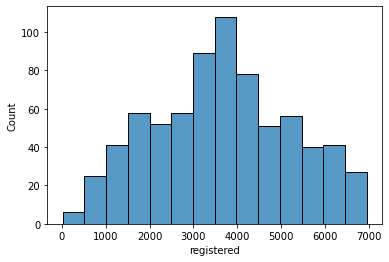

In [ ]:
sns.histplot(df["registered"]) ;

In [ ]:
stats.shapiro(df["registered"])

ShapiroResult(statistic=0.98438560962677, pvalue=5.023745757171127e-07)

- Nuestro pvalor es menor a 0.05, con lo cual nuestros datos no son normales.

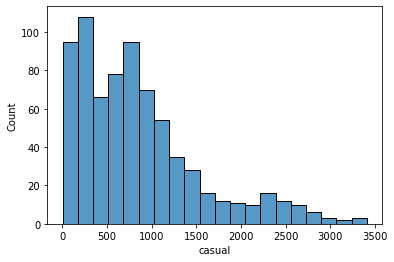

In [ ]:
sns.histplot(df["casual"]) ;

In [ ]:
stats.shapiro(df["casual"])

ShapiroResult(statistic=0.8850967288017273, pvalue=7.660028716313278e-23)

- El p-valor para la columna *casual* también es menor de 0.05, por lo que no cumple la asunción de normalidad

## Normalización de la variable respuesta: "registered"

In [ ]:
minmax = MinMaxScaler()

In [ ]:
minmax.fit(df[["registered"]])

MinMaxScaler()

In [ ]:
x_norm = minmax.transform(df[["registered"]])


In [ ]:
x_norm.min(axis=0)

array([0.])

In [ ]:
x_norm.max(axis=0)

array([1.])

In [ ]:
num_minmax = pd.DataFrame(x_norm, columns=["registered_Sklearn"])

In [ ]:
df["registered_Sklearn"]= num_minmax

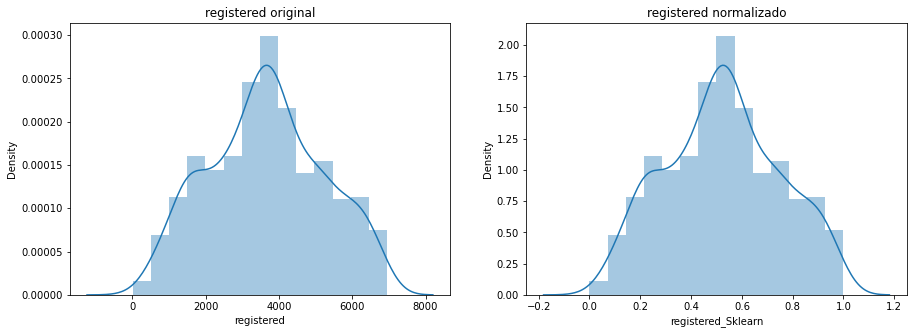

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('registered original')
axes[1].set_title('registered normalizado')

sns.distplot(df['registered'] ,ax = axes[0])
sns.distplot(df['registered_Sklearn'], ax = axes[1]);

In [ ]:
stats.shapiro(df["registered_Sklearn"])

ShapiroResult(statistic=0.98438560962677, pvalue=5.023745757171127e-07)

Probamos con el BOX-COX:

In [ ]:
df['registered_BOX'], lambda_ajustada = stats.boxcox(df['registered'])

In [ ]:
stats.shapiro(df["registered_BOX"])

ShapiroResult(statistic=0.9854231476783752, pvalue=1.1639369859040016e-06)

Sigue sin normalizar

## Normalización de la variable respuesta: "casual"

In [ ]:
minmax2 = MinMaxScaler()

In [ ]:
minmax2.fit(df[["casual"]])

MinMaxScaler()

In [ ]:
x_norm2 = minmax2.transform(df[["casual"]])

In [ ]:
x_norm2.min(axis=0)

array([0.])

In [ ]:
x_norm2.max(axis=0)

array([1.])

In [ ]:
num_minmax2 = pd.DataFrame(x_norm2, columns=["casual_Sklearn"])

In [ ]:
df["casual_Sklearn"]= num_minmax2

In [ ]:
df["casual_Sklearn"]= num_minmax2

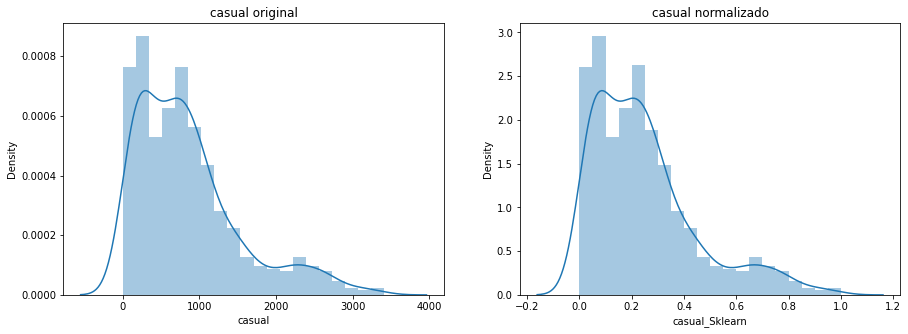

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('casual original')
axes[1].set_title('casual normalizado')

sns.distplot(df['casual'] ,ax = axes[0])
sns.distplot(df['casual_Sklearn'], ax = axes[1]);

In [ ]:
stats.shapiro(df["casual_Sklearn"])

ShapiroResult(statistic=0.8850969076156616, pvalue=7.660317123860226e-23)

Probamos con el BOX-COX

In [ ]:
df['casual_BOX'], lambda_ajustada = stats.boxcox(df['casual'])

In [ ]:
stats.shapiro(df["casual_BOX"])

ShapiroResult(statistic=0.9915913939476013, pvalue=0.000365116517059505)

Tampoco podemos normalizarla. No cumple 1 de las 3 asunciones, por lo que no podemos hacer el ANOVA

## Asunción de dependencia

In [ ]:
num = df.select_dtypes(include=np.number).drop("registered", axis = 1)

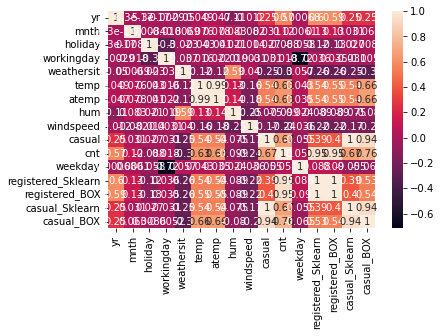

In [ ]:
sns.heatmap(num.corr(), annot=True) ;

- Observamos que la columna atemp está muy relacionada con la temp, por lo que decidimos eliminarla.

In [ ]:
df.drop("atemp", axis=1, inplace= True)

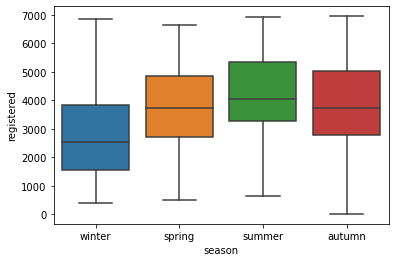

In [ ]:
sns.boxplot(y= "registered", x="season", data = df);

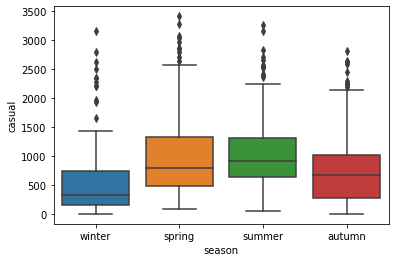

In [ ]:
sns.boxplot(y= "casual", x = "season", data = df);

Comprobamos que "registered", efectiavamente, es la mejor opción, dado que no tiene outliers, cuando "casual" sí. No obstante, nos tranquiliza saber que los datos son relativamente similares, a pesar de una pequeña diferencia en "winter".

In [16]:
df_registered = pd.read_csv("../datos/bikes_registered.csv", index_col = 0).reset_index()

In [6]:
df_registered.head(2)

,instant,season,yr,mnth,holiday,workingday,weathersit,temp,atemp,hum,windspeed,registered,weekday
0,1,winter,0,1,1,0,2,14.110847,18.18125,80.5833,10.749882,654,1
1,2,winter,0,2,0,1,2,14.902598,17.68695,69.6087,16.652113,670,4


In [17]:
df_casual = pd.read_csv("../datos/bikes_casual.csv", index_col= 0).reset_index()
df_casual.head(2)

,instant,season,yr,mnth,holiday,workingday,weathersit,temp,atemp,hum,windspeed,casual,weekday
0,1,winter,0,1,1,0,2,14.110847,18.18125,80.5833,10.749882,331,1
1,2,winter,0,2,0,1,2,14.902598,17.68695,69.6087,16.652113,131,4


sklearn entenderá los valores numéricos como **encoding**.

- Year : El encoding estaría bien hecho ya porque el año 1 hay más bicis alquiladas
- Workingday : El encoding también estaría bien
- Weathersit : El encoding sería 1 - 2, para el 2 le ponemos un 1 y para el 3 le ponemos un 0

- Season : Hay que hacerlo. Verano 2, primavera y otoño 1, winter 0
- month lo borraremos porque nos da la misma información que las estaciones

## ENCODING

Empezamos por el weathersit

- Year : El encoding estaría bien hecho ya porque el año 1 hay más bicis alquiladas
- Workingday : El encoding también estaría bien
- Weathersit : El encoding sería 1 - 2, para el 2 le ponemos un 1 y para el 3 le ponemos un 0
- Season : Hay que hacerlo. Verano 2, primavera y otoño 1, winter 0
- month lo borraremos porque nos da la misma información que las estaciones
- Weekday : Hacemos un map diferente para registered y para casual

In [18]:
mapa = {3:0, 2:1, 1:2} 

In [19]:
df_registered["weathersit"] = df_registered["weathersit"].map(mapa)

In [20]:
df_casual["weathersit"] = df_casual["weathersit"].map(mapa)

In [21]:
mapa2 = {"winter":0, "autumn":1, "spring":1, "summer":2} 

In [22]:
df_registered["season"] = df_registered["season"].map(mapa2)

In [23]:
df_casual["season"] = df_casual["season"].map(mapa2)

In [24]:
mapa_weekday_regist = {1: 0, 2:0, 3: 1, 4: 2, 5: 2, 6:2, 7:0}
mapa_weekday_casual = {1: 2, 2: 1, 3: 0, 4:0, 5: 0, 6:0, 7:1}

In [25]:
df_registered["weekday"] = df_registered["weekday"].map(mapa_weekday_regist)
df_casual["weekday"] = df_casual["weekday"].map(mapa_weekday_casual)

In [26]:
df_casual.head()

,instant,season,yr,mnth,holiday,workingday,weathersit,temp,atemp,hum,windspeed,casual,weekday
0,1,0,0,1,1,0,1,14.110847,18.18125,80.5833,10.749882,331,2
1,2,0,0,2,0,1,1,14.902598,17.68695,69.6087,16.652113,131,0
2,3,0,0,3,0,1,2,8.050924,9.47025,43.7273,16.636703,120,0
3,4,1,0,4,0,0,2,8.200000,10.60610,59.0435,10.739832,108,1
4,5,1,0,5,0,1,2,9.305237,11.46350,43.6957,12.522300,82,1


In [27]:
df_registered.head(2)

,instant,season,yr,mnth,holiday,workingday,weathersit,temp,atemp,hum,windspeed,registered,weekday
0,1,0,0,1,1,0,1,14.110847,18.18125,80.5833,10.749882,654,0
1,2,0,0,2,0,1,1,14.902598,17.68695,69.6087,16.652113,670,2


Guardamos los csv:

In [28]:
df_casual.to_csv("../datos/bikes_casual_sinest.csv")

In [29]:
df_registered.to_csv("../datos/bikes_registered_sinest.csv")

## ESTANDARIZACION

In [30]:
df_casual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   season      730 non-null    int64  
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  casual      730 non-null    int64  
 12  weekday     730 non-null    int64  
dtypes: float64(4), int64(9)
memory usage: 74.3 KB


In [31]:
num = df_casual[["atemp", "hum", "windspeed"]]

In [32]:
num.head()

,atemp,hum,windspeed
0,18.18125,80.5833,10.749882
1,17.68695,69.6087,16.652113
2,9.47025,43.7273,16.636703
3,10.60610,59.0435,10.739832
4,11.46350,43.6957,12.522300


In [33]:
# construir el modelo de escalador
robust = RobustScaler()

In [34]:
# ajustamos el modelo utilizando nuestro set de datos
robust.fit(num)

RobustScaler()

In [35]:
# transformamos los datos
X_robust = robust.transform(num)

In [36]:
numericas_robust = pd.DataFrame(X_robust, columns = num.columns)
numericas_robust.head(2)

,atemp,hum,windspeed
0,-0.456399,0.855582,-0.208909
1,-0.492863,0.332722,0.687550


In [37]:
# vamos a guardar este dataframe para seguir trabajando en la siguiente lección de Encoding con el. Pero antes de eso tenemos que juntar los resultados de la estandarización
## a nuestro dataframe original

df_casual[numericas_robust.columns] = numericas_robust
df_casual.head()

,instant,season,yr,mnth,holiday,workingday,weathersit,temp,atemp,hum,windspeed,casual,weekday
0,1,0,0,1,1,0,1,14.110847,-0.456399,0.855582,-0.208909,331,2
1,2,0,0,2,0,1,1,14.902598,-0.492863,0.332722,0.687550,131,0
2,3,0,0,3,0,1,2,8.050924,-1.098990,-0.900337,0.685210,120,0
3,4,1,0,4,0,0,2,8.200000,-1.015201,-0.170632,-0.210435,108,1
4,5,1,0,5,0,1,2,9.305237,-0.951952,-0.901843,0.060294,82,1


In [38]:
df_registered[numericas_robust.columns] = numericas_robust
df_registered.head()

,instant,season,yr,mnth,holiday,workingday,weathersit,temp,atemp,hum,windspeed,registered,weekday
0,1,0,0,1,1,0,1,14.110847,-0.456399,0.855582,-0.208909,654,0
1,2,0,0,2,0,1,1,14.902598,-0.492863,0.332722,0.687550,670,2
2,3,0,0,3,0,1,2,8.050924,-1.098990,-0.900337,0.685210,1229,2
3,4,1,0,4,0,0,2,8.200000,-1.015201,-0.170632,-0.210435,1454,0
4,5,1,0,5,0,1,2,9.305237,-0.951952,-0.901843,0.060294,1518,0


In [39]:
df_casual.to_csv("../datos/bikes_casual_estan.csv")

In [40]:
df_registered.to_csv("../datos/bikes_registered_estan.csv")